In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
results_path = Path('../../../results/all/experiment_results.csv')
df = pd.read_csv(results_path)

# Filter for synthetic datasets
synthetic_datasets = ['A', 'B', 'C', 'D', 'E']
df_synthetic = df[df['dataset_id'].isin(synthetic_datasets)]

print(f"Loaded {len(df_synthetic)} synthetic experiments")
print(f"Methods: {df_synthetic['model_name'].unique()}")
print(f"Datasets: {df_synthetic['dataset_id'].unique()}")


Loaded 60 synthetic experiments
Methods: ['nimo' 'random_forest' 'nimo_baseline']
Datasets: ['A' 'B' 'C' 'D' 'E']


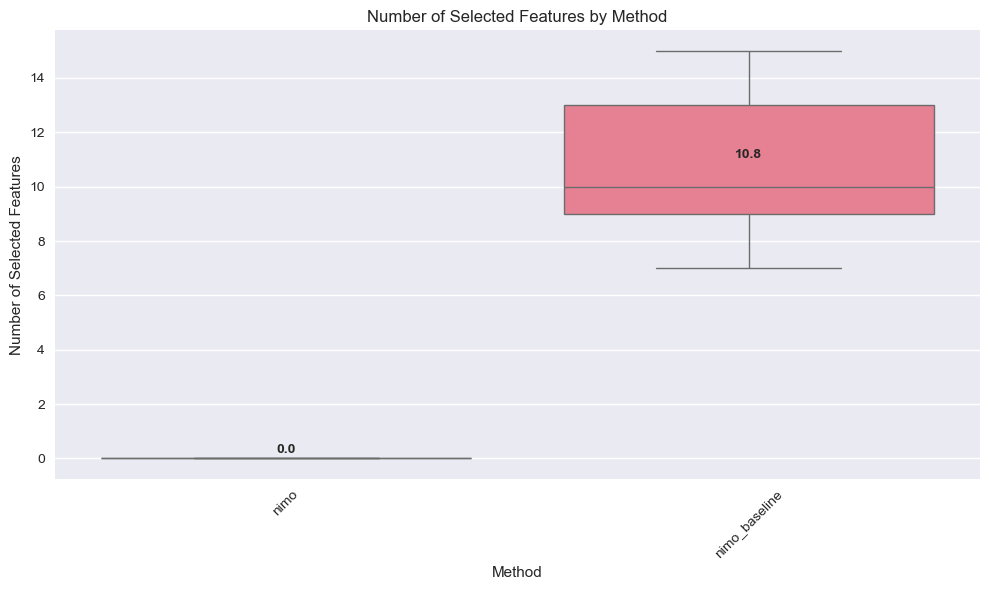

\n=== FEATURE SELECTION SUMMARY (True Feature Selection Methods Only) ===
                mean   std  min  max
model_name                          
nimo            0.00  0.00    0    0
nimo_baseline  10.85  2.52    7   15
\n=== EXCLUDED METHODS ===
Neural Network: Uses all features, no feature selection
Random Forest: Uses all features, 'n_selected' based on importance threshold > 0.01
These methods are excluded as they don't perform true feature selection.


In [15]:
# 1. Feature Selection Counts by Method (True Feature Selection Only)
plt.figure(figsize=(10, 6))

# Filter for methods that do true feature selection
feature_selection_methods = ['lasso', 'lassonet', 'nimo', 'nimo_baseline']
df_feature_selection = df_synthetic[df_synthetic['model_name'].isin(feature_selection_methods)]

# Create boxplot for number of selected features
sns.boxplot(data=df_feature_selection, x='model_name', y='n_selected')
plt.title('Number of Selected Features by Method')
plt.xlabel('Method')
plt.ylabel('Number of Selected Features')
plt.xticks(rotation=45)

# Add mean values as text
means = df_feature_selection.groupby('model_name')['n_selected'].mean()
for i, (method, mean) in enumerate(means.items()):
    plt.text(i, mean + 0.1, f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\\n=== FEATURE SELECTION SUMMARY (True Feature Selection Methods Only) ===")
selection_summary = df_feature_selection.groupby('model_name')['n_selected'].agg(['mean', 'std', 'min', 'max']).round(2)
print(selection_summary)

print("\\n=== EXCLUDED METHODS ===")
print("Neural Network: Uses all features, no feature selection")
print("Random Forest: Uses all features, 'n_selected' based on importance threshold > 0.01")
print("These methods are excluded as they don't perform true feature selection.")



LASSO vs NIMO COEFFICIENT COMPARISON

Dataset A:
  True features: [0, 1, 2, 3]
  Features selected by Lasso/NIMO: []
  Features: ['intercept', 'f0', 'f1', 'f2', 'f3']


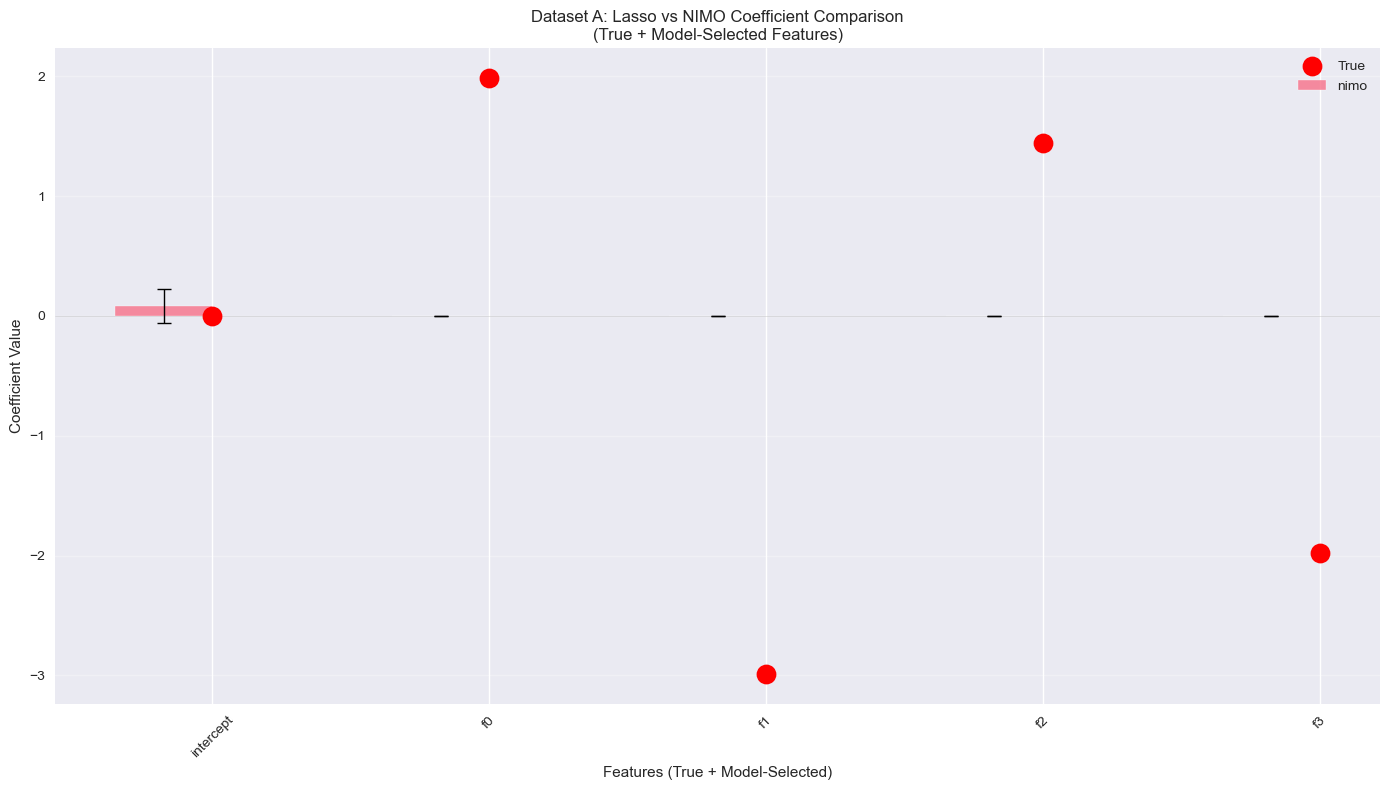

True beta values: ['2.000', '-3.000', '1.500', '-2.000']
Mean |β| (true): 1.680

--- DATASET A - BEST ITERATION COEFFICIENTS ---
NIMO: Best iteration 0 (F1: 0.667) - 0 features selected
Debug: Using raw true coefficients (not standardized)
Debug: true_coefs_std shape: (11,), type: <class 'numpy.ndarray'>


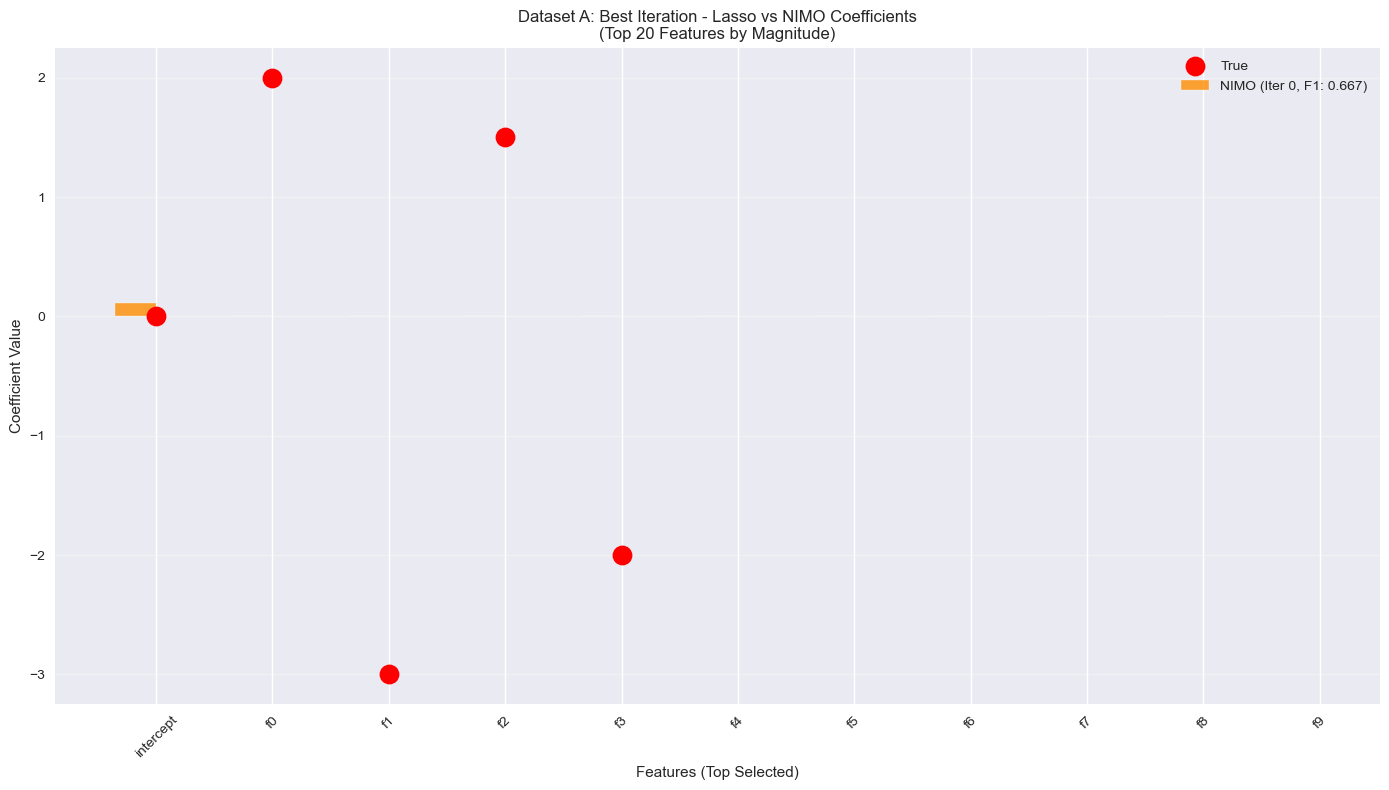


Best iterations:
  NIMO: Iteration 0 (F1: 0.667)


Dataset B:
  True features: [0, 1, 2, 3]
  Features selected by Lasso/NIMO: []
  Features: ['intercept', 'f0', 'f1', 'f2', 'f3']


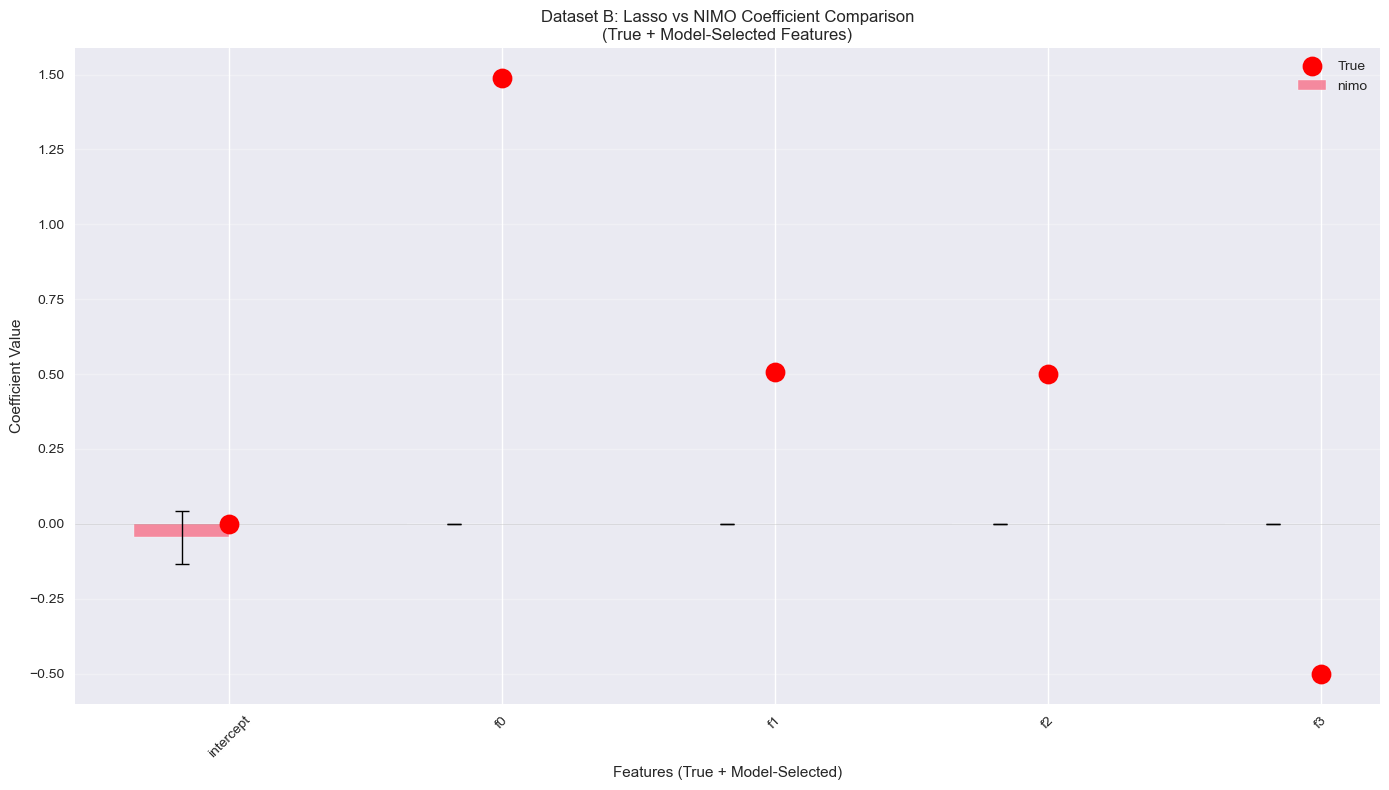

True beta values: ['1.500', '0.500', '0.500', '-0.500']
Mean |β| (true): 0.600

--- DATASET B - BEST ITERATION COEFFICIENTS ---
NIMO: Best iteration 0 (F1: 0.661) - 0 features selected
Debug: Using raw true coefficients (not standardized)
Debug: true_coefs_std shape: (11,), type: <class 'numpy.ndarray'>


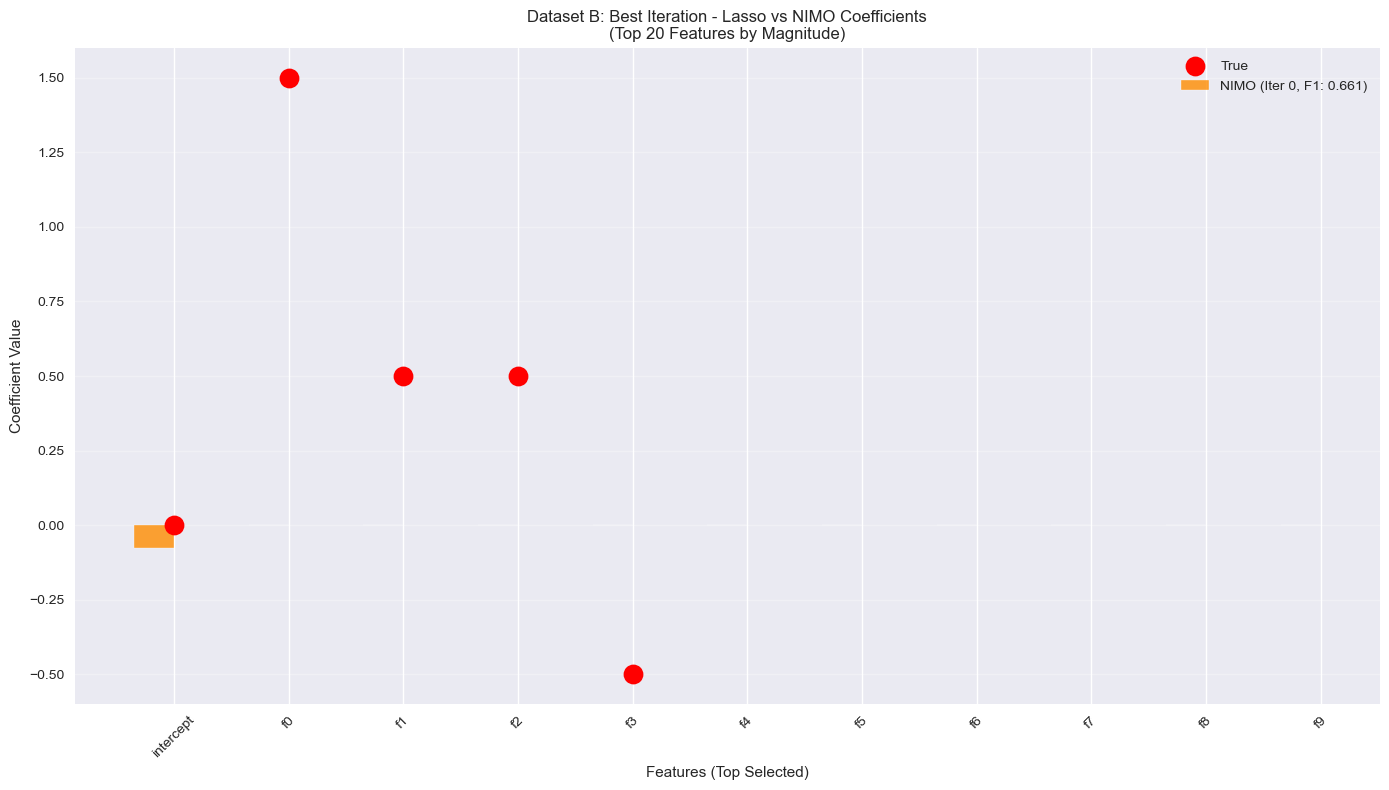


Best iterations:
  NIMO: Iteration 0 (F1: 0.661)


Dataset C:
  True features: [0, 1, 2, 3]
  Features selected by Lasso/NIMO: []
  Features: ['intercept', 'f0', 'f1', 'f2', 'f3']


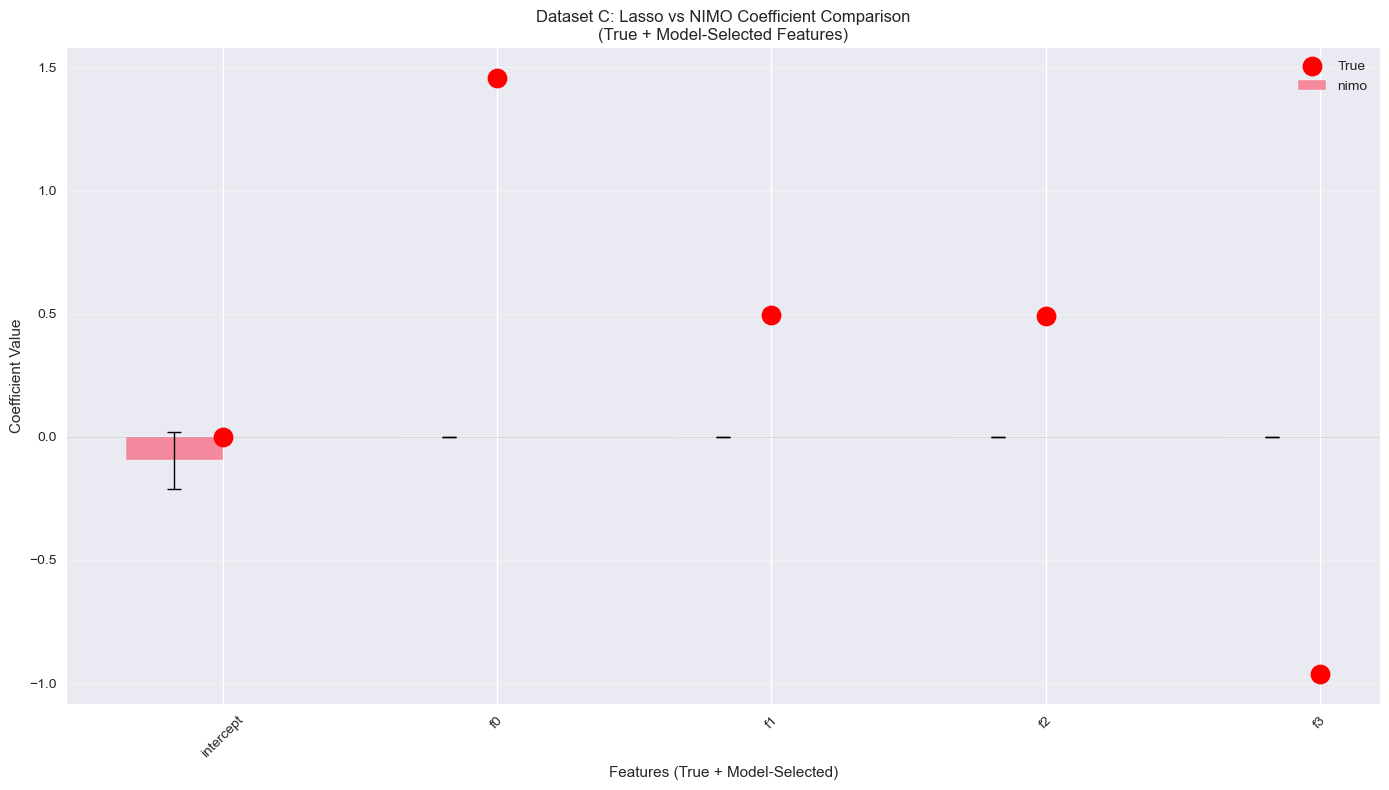

True beta values: ['1.500', '0.500', '0.500', '-1.000']
Mean |β| (true): 0.682

--- DATASET C - BEST ITERATION COEFFICIENTS ---
NIMO: Best iteration 0 (F1: 0.658) - 0 features selected
Debug: Using raw true coefficients (not standardized)
Debug: true_coefs_std shape: (11,), type: <class 'numpy.ndarray'>


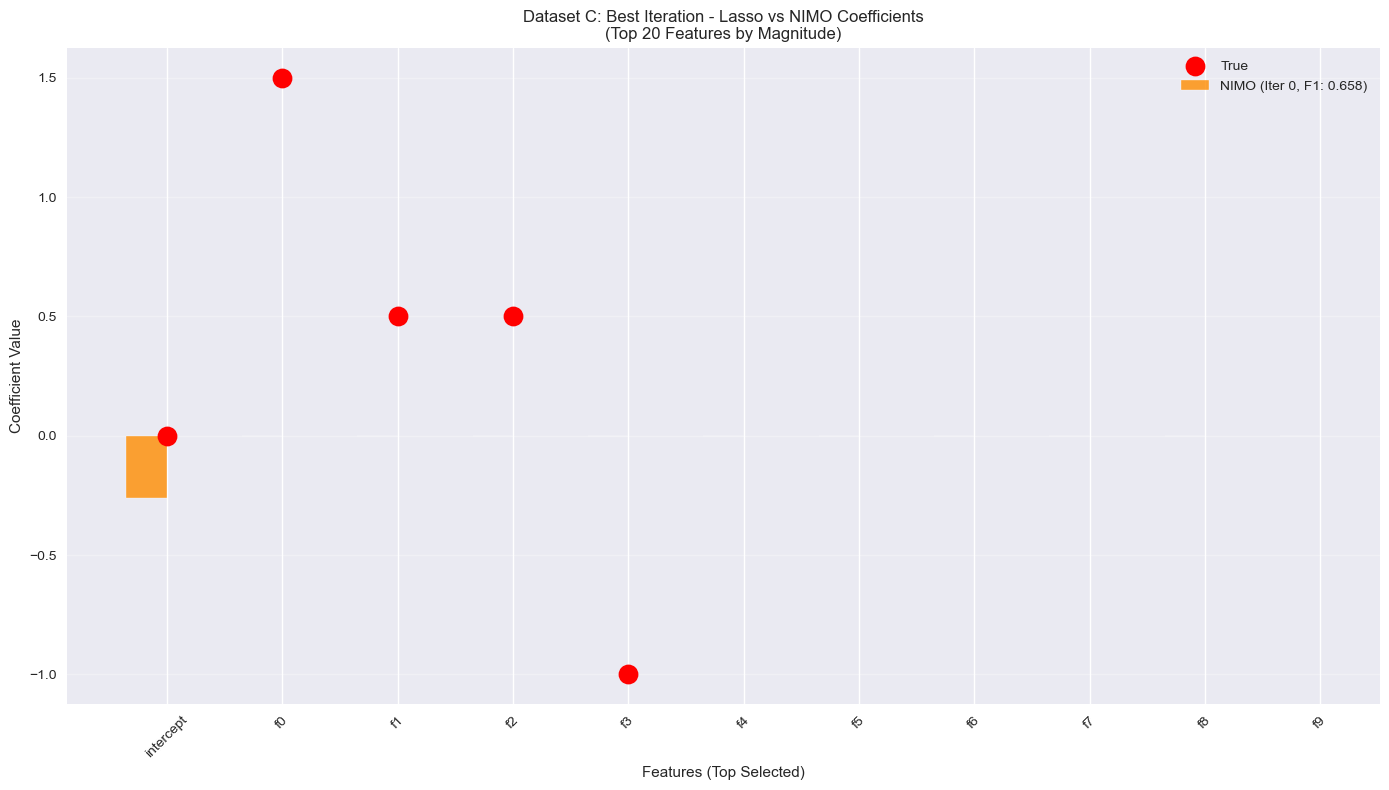


Best iterations:
  NIMO: Iteration 0 (F1: 0.658)


Dataset D:
  True features: [0, 2, 4]
  Features selected by Lasso/NIMO: []
  Features: ['intercept', 'f0', 'f2', 'f4']


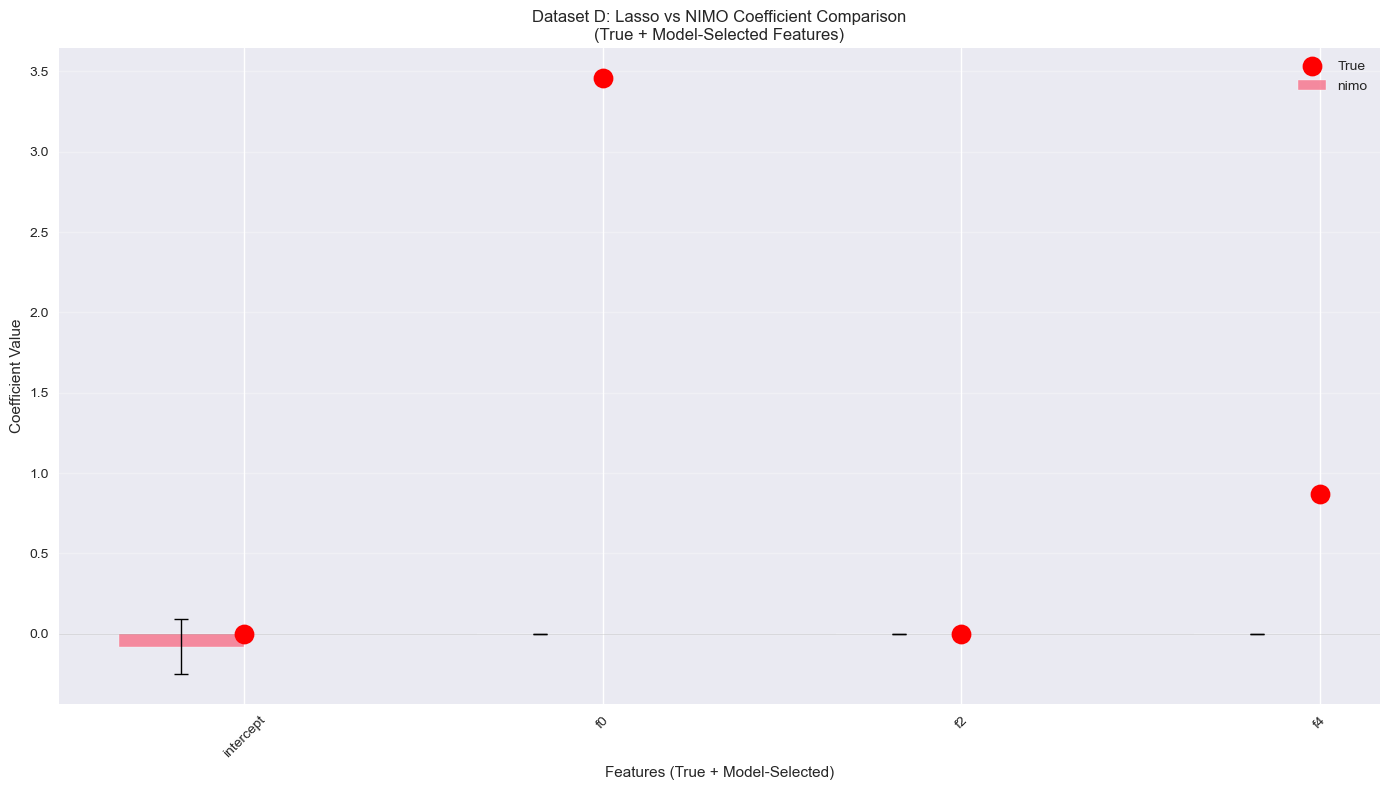

IndexError: list index out of range

In [16]:
# 3. Lasso vs NIMO Coefficients Comparison (copied from 05_plot_synthetic_results.ipynb)

# Helper function to convert raw beta to standardized space
def raw_to_std(beta_raw, b0_raw, mu, s, true_support=None):
    """Convert raw beta to standardized space for comparison."""
    beta_raw = np.asarray(beta_raw, float)
    mu = np.asarray(mu, float)
    s = np.asarray(s, float)
    
    # If true_support is provided, we need to map the beta values to the full feature space
    if true_support is not None and len(beta_raw) < len(mu):
        # Create full beta vector with zeros for non-true features
        beta_full = np.zeros(len(mu))
        beta_full[true_support] = beta_raw
        beta_raw = beta_full
    
    beta_std = s * beta_raw                     # elementwise
    b0_std = b0_raw + float(np.dot(mu, beta_raw))
    return beta_std, b0_std

# Coefficient Analysis (with ground truth) - Bar plots with error bars
print("\n" + "=" * 80)
print("LASSO vs NIMO COEFFICIENT COMPARISON")
print("=" * 80)

TOPK = 20  # Number of top features to show

for dataset in synthetic_datasets:
    # Get the first row to extract true beta (same for all iterations in a scenario)
    row = df_synthetic[df_synthetic["dataset_id"] == dataset].iloc[0]
    beta_true_raw = json.loads(row["beta_true"])
    true_support = json.loads(row["true_support"])
    b0_true_raw = 0.0  # Default intercept

    p = len(beta_true_raw)
    
    # Get features selected by Lasso and NIMO
    model_selected_features = set()
    for m in ['lasso', 'nimo']:
        sub = df_synthetic[(df_synthetic["dataset_id"] == dataset) & (df_synthetic["model_name"] == m)]
        if len(sub) > 0:
            coefs_dict = json.loads(sub.iloc[0]["coefficients"])
            coefs = coefs_dict.get("values", [])
            if coefs:
                non_zero_idx = np.where(np.array(coefs) != 0)[0]
                model_selected_features.update(non_zero_idx)
    
    # Combine true features with model-selected features
    all_important_features = set(true_support) | model_selected_features
    all_important_features = sorted(list(all_important_features))
    
    # Take top features, prioritizing true features first
    true_features_first = true_support + [f for f in all_important_features if f not in true_support]
    top_idx = true_features_first[:min(TOPK, len(true_features_first))]
    
    # Add intercept as first column (index -1 represents intercept)
    labels = ["intercept"] + [f"f{j}" for j in top_idx]
    # Adjust top_idx to include intercept position
    top_idx_with_intercept = [-1] + top_idx  # -1 represents intercept
    
    print(f"\nDataset {dataset}:")
    print(f"  True features: {true_support}")
    print(f"  Features selected by Lasso/NIMO: {sorted(list(model_selected_features))}")
    print(f"  Features: {labels}")

    # Collect coefficients from ALL iterations for error bar calculation
    all_coefs = {model: [] for model in ['lasso', 'nimo']}
    beta_true_std = None  # Will be computed once using the first model's scaler
    b0_true_std = None

    for m in ['lasso', 'nimo']:
        sub = df_synthetic[(df_synthetic["dataset_id"] == dataset) & (df_synthetic["model_name"] == m)]
        if len(sub) == 0:
            continue
            
        for _, model_row in sub.iterrows():
            try:
                coefs_dict = json.loads(model_row["coefficients"])
                coefs = coefs_dict.get("values", [])
                mu = coefs_dict.get("mean", np.zeros(p))
                s = coefs_dict.get("scale", np.ones(p))
                
                # Convert true beta to standardized space using this model's scaler
                if beta_true_std is None:
                    beta_true_std, b0_true_std = raw_to_std(beta_true_raw, b0_true_raw, mu, s, true_support)

                if coefs and len(coefs) == len(mu):
                    # Get intercept and feature coefficients
                    intercept = coefs_dict.get("intercept", 0.0)
                    coefs_array = np.array(coefs)[top_idx]
                    # Combine intercept and feature coefficients
                    coefs_with_intercept = np.concatenate([[intercept], coefs_array])
                    all_coefs[m].append(coefs_with_intercept)
                    
            except Exception as e:
                print(f"Warning: Could not parse coefficients for {m}: {e}")
                continue

    # Calculate means and standard errors for each model
    model_means = {}
    model_stds = {}
    
    for m in ['lasso', 'nimo']:
        if len(all_coefs[m]) > 0:
            coefs_matrix = np.array(all_coefs[m])  # Shape: (n_iterations, n_features)
            model_means[m] = np.mean(coefs_matrix, axis=0)
            model_stds[m] = np.std(coefs_matrix, axis=0)
        else:
            print(f"Warning: No valid coefficients for {m} in dataset {dataset}")

    # Plot coefficient comparison if we have valid data
    if beta_true_std is not None and len(model_means) > 0:
        plt.figure(figsize=(14, 8))
        
        x = np.arange(len(labels))
        width = 0.35  # Width of bars
        
        # True coefficients (standardized) - as horizontal line
        # Add intercept (0) and feature coefficients
        beta_true_intercept = 0.0  # Ground truth intercept is always 0
        beta_true_top = np.concatenate([[beta_true_intercept], beta_true_std[top_idx]])
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
        
        # Plot bars for each model
        for i, (model, means) in enumerate(model_means.items()):
            stds = model_stds[model]
            x_pos = x + i * width - width/2  # Offset bars
            bars = plt.bar(x_pos, means, width, 
                          label=f'{model}', 
                          alpha=0.8,
                          yerr=stds, 
                          capsize=5,
                          error_kw={'elinewidth': 1, 'capthick': 1})
        
        # Add true coefficients as red circles (intercept + true features only)
        # Show ground truth for intercept (always 0) and true features
        true_feature_mask = np.array([True] + [i in true_support for i in top_idx])  # Include intercept
        if np.any(true_feature_mask):
            true_x = x[true_feature_mask]
            true_y = beta_true_top[true_feature_mask]
            plt.scatter(true_x, true_y, 
                       color='red', s=150, marker='o', 
                       label='True', zorder=10, linewidth=2)
        
        plt.xlabel('Features (True + Model-Selected)')
        plt.ylabel('Coefficient Value')
        plt.title(f'Dataset {dataset}: Lasso vs NIMO Coefficient Comparison\n(True + Model-Selected Features)')
        plt.xticks(x, labels, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print(f"True beta values: {[f'{beta_true_raw[i]:.3f}' for i in true_support]}")
        print(f"Mean |β| (true): {np.mean(np.abs(beta_true_top)):.3f}")
        
        # ===== BEST ITERATION PLOT =====
        print(f"\n--- DATASET {dataset} - BEST ITERATION COEFFICIENTS ---")
        
        # Find best iteration for each model (Lasso and NIMO)
        best_iterations = {}
        for m in ['lasso', 'nimo']:
            sub = df_synthetic[(df_synthetic["dataset_id"] == dataset) & (df_synthetic["model_name"] == m)]
            if len(sub) > 0:
                f1_scores = sub['f1'].dropna()
                if len(f1_scores) > 0:
                    best_idx = f1_scores.idxmax()
                    best_iterations[m] = sub.loc[best_idx]
                else:
                    best_iterations[m] = sub.iloc[0]  # Fallback to first iteration
        
        # Get coefficients from best iterations
        best_coefs = {}
        best_feature_labels = None
        
        for m in ['lasso', 'nimo']:
            if m in best_iterations:
                best_iter = best_iterations[m]
                try:
                    coefs_dict = json.loads(best_iter["coefficients"])
                    coefs = coefs_dict.get("values", [])
                    if len(coefs) > 0:
                        coefs_array = np.array(coefs)
                        # Get features in order: first true features, then others by magnitude
                        # Note: coefs_array already excludes intercept (it's stored separately)
                        true_features_ordered = []
                        for i in true_support:
                            if i < len(coefs_array):
                                true_features_ordered.append(i)
                        
                        # Then get other features by magnitude
                        other_features = []
                        for i in range(len(coefs_array)):
                            if i not in true_support:
                                other_features.append(i)
                        
                        # Sort other features by magnitude
                        other_features_sorted = sorted(other_features, key=lambda i: abs(coefs_array[i]), reverse=True)
                        
                        # Combine: true features first, then others (up to TOPK total)
                        top_idx = true_features_ordered + other_features_sorted[:TOPK - len(true_features_ordered)]
                        
                        # Add intercept as first element
                        intercept = coefs_dict.get("intercept", 0.0)
                        best_coefs[m] = np.concatenate([[intercept], coefs_array[top_idx]])
                        
                        if best_feature_labels is None:
                            best_feature_labels = ["intercept"] + [f"f{i}" for i in top_idx]
                        
                        print(f"{m.upper()}: Best iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f}) - {np.sum(coefs_array != 0)} features selected")
                except Exception as e:
                    print(f"Warning: Could not parse coefficients for {m}: {e}")
        
        # Plot best iteration coefficients if we have data
        if len(best_coefs) > 0 and best_feature_labels is not None:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(best_feature_labels))
            width = 0.35
            
            # Calculate true coefficients for best iteration plot (standardized)
            true_coefs_std = None
            if len(best_coefs) > 0:
                try:
                    # Get true coefficients for the same features (including intercept)
                    true_coefs_raw = [0.0]  # Intercept is always 0
                    for i in top_idx:
                        if i < len(beta_true_raw):
                            true_coefs_raw.append(beta_true_raw[i])
                        else:
                            true_coefs_raw.append(0.0)  # Non-true features have 0 coefficient
                    
                    # Convert to numpy array and ensure it's 1D
                    true_coefs_raw = np.array(true_coefs_raw, dtype=float)
                    
                    # For now, use raw coefficients to avoid standardization issues
                    # TODO: Implement proper standardization later
                    true_coefs_std = true_coefs_raw
                    
                    print(f"Debug: Using raw true coefficients (not standardized)")
                    print(f"Debug: true_coefs_std shape: {true_coefs_std.shape}, type: {type(true_coefs_std)}")
                    
                except Exception as e:
                    print(f"Warning: Could not calculate true coefficients: {e}")
                    true_coefs_std = None
            
            # Plot bars for each model's best iteration
            for i, (model, coefs) in enumerate(best_coefs.items()):
                best_iter = best_iterations[model]
                x_pos = x + i * width - width/2
                
                # Use different colors for selected vs non-selected features
                base_color = 'steelblue' if model == 'lasso' else 'darkorange'
                colors = [base_color if abs(c) > 1e-6 else 'lightgray' for c in coefs]
                
                bars = plt.bar(x_pos, coefs, width, 
                              label=f'{model.upper()} (Iter {best_iter["iteration"]}, F1: {best_iter["f1"]:.3f})', 
                              color=colors, alpha=0.8)
            
            # Add true features as circles (intercept + true features only)
            if true_coefs_std is not None:
                # Show ground truth for intercept (always 0) and true features
                true_feature_mask = np.array([True] + [i in true_support for i in top_idx])  # Include intercept
                if np.any(true_feature_mask):
                    true_x = x[true_feature_mask]
                    true_y = true_coefs_std[true_feature_mask]
                    plt.scatter(true_x, true_y, 
                               color='red', s=150, marker='o', 
                               label='True', zorder=10, linewidth=2)
            
            plt.xlabel('Features (Top Selected)')
            plt.ylabel('Coefficient Value')
            plt.title(f'Dataset {dataset}: Best Iteration - Lasso vs NIMO Coefficients\n(Top {TOPK} Features by Magnitude)')
            plt.xticks(x, best_feature_labels, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            # Show which iterations had best performance
            print(f"\nBest iterations:")
            for m in ['lasso', 'nimo']:
                if m in best_iterations:
                    best_iter = best_iterations[m]
                    print(f"  {m.upper()}: Iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f})")
        
        print(f"\n{'='*80}")
